# Brain Tumor Classification (LGG vs. HGG) - Training Notebook

This Kaggle notebook details the training process for the 3D CNN model used for classifying brain tumors as Low-Grade Glioma (LGG) or High-Grade Glioma (HGG).

**The complete project codebase, including data preprocessing scripts, evaluation utilities, detailed documentation, and the final model outputs, is maintained in the main GitHub repository:**

 **GitHub Repository: [https://github.com/your-github-username/brain_tumor_detection](https://github.com/your-github-username/brain_tumor_detection)**

This notebook focuses specifically on the model training phase as conducted within the Kaggle environment. Please refer to the GitHub repository for instructions on setting up the full environment, running preprocessing, and performing evaluation with the trained model.

In [1]:
# 📌 Install the last 2.2-series CUDA 11.8 wheels
!pip install --quiet --no-cache-dir \
  torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 \
  -f https://download.pytorch.org/whl/cu118

In [2]:
%%writefile requirements.txt
torchvision==0.16.0
torchaudio==2.1.0
monai==1.3.0
tqdm==4.66.1
absl-py==2.1.0
astunparse==1.6.3
certifi==2024.8.30
charset-normalizer==3.3.2
contourpy==1.3.0
cycler==0.12.1
flatbuffers==24.3.25
fonttools==4.53.1
gast==0.6.0
google-pasta==0.2.0
grpcio==1.66.1
h5py==3.11.0
idna==3.10
importlib_metadata==8.5.0
importlib_resources==6.4.5
joblib==1.4.2
kiwisolver==1.4.7
libclang==18.1.1
Markdown==3.7
markdown-it-py==3.0.0
MarkupSafe==2.1.5
mdurl==0.1.2
ml-dtypes==0.3.2
namex==0.0.8
nibabel==5.2.1
numpy==1.26.4
opencv-python==4.10.0.84
opt-einsum==3.3.0
optree==0.12.1
packaging==24.1
pandas==2.2.2
pillow==10.4.0
protobuf==4.25.4
Pygments==2.18.0
pyparsing==3.1.4
python-dateutil==2.9.0.post0
pytz==2024.2
requests==2.32.3
rich==13.8.1
scikit-learn==1.5.2
scipy==1.13.1
seaborn==0.13.2
six==1.16.0
termcolor==2.4.0
threadpoolctl==3.5.0
typeguard==2.13.3
typing_extensions==4.12.2
tzdata==2024.1
urllib3==2.2.3
Werkzeug==3.0.4
wrapt==1.16.0
zipp==3.20.2


Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt

  Using cached torchvision-0.16.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (5.7 kB)
  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.metadata (1.8 kB)
  Using cached triton-2.1.0-0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
Using cached torchvision-0.16.0-cp311-cp311-manylinux1_x86_64.whl (6.9 MB)
Using cached torchaudio-2.1.0-cp311-cp311-manylinux1_x86_64.whl (3.3 MB)
Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl (670.2 MB)
Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
Using cached triton-2.1.0-0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attemptin

## 1. Setup and Imports
All necessary libraries are imported here. Ensure your Kaggle environment has these packages installed. `requirements.txt` from the original project can be used as a reference if needed, but Kaggle often pre-installs many common libraries.

In [4]:
import os
import time
import glob
import json # For potential metadata saving, though not heavily used yet
import shutil # For directory cleanup if needed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import monai
from monai.data import CacheDataset, PersistentDataset # Using MONAI's caching datasets
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    RandFlipd,
    RandRotate90d,
    ConcatItemsd,
    EnsureTyped
)
from monai.networks.nets import resnet50

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm # Use tqdm.notebook for Kaggle

import matplotlib.pyplot as plt
import seaborn as sns

import logging

# Setup basic logging for the notebook
# In a notebook, print statements are often more immediate, but logging can be useful for tracking.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler()]) # StreamHandler to output to notebook console
logger = logging.getLogger()

2025-05-30 13:00:01.753750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748610001.776180     175 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748610001.783043     175 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Configuration

Define all paths, hyperparameters, and settings.
**Important:** Adjust `KAGGLE_INPUT_DIR` to match your dataset path on Kaggle (e.g., `"/kaggle/input/your-dataset-folder-name/"`).
Outputs (models, logs, preprocessed data) will go to `/kaggle/working/`.

In [16]:
# --- Kaggle Path Configuration ---
# !!! ADJUST THIS if your Kaggle input dataset has a different name !!!
KAGGLE_INPUT_DIR = "/kaggle/input/elf-dataset-pytorch"
KAGGLE_WORKING_DIR = "/kaggle/working/"

# --- Project Structure based on Kaggle Paths ---
BASE_DIR = KAGGLE_WORKING_DIR # Project root within Kaggle's writable directory
DATA_DIR = os.path.join(KAGGLE_WORKING_DIR, 'data') # For local data structure if needed
MODEL_DIR = os.path.join(KAGGLE_WORKING_DIR, 'models')
LOG_DIR = os.path.join(KAGGLE_WORKING_DIR, 'logs') # Logs will also go to console
PLOTS_DIR = os.path.join(KAGGLE_WORKING_DIR, "plots") # Plots 

# --- Data Paths ---
# RAW_DATA_DIR should point to where your raw NIfTI files and name_mapping.csv are in the Kaggle input.
# Example: if name_mapping.csv is at /kaggle/input/my-dataset/name_mapping.csv
# and subject folders are in /kaggle/input/my-dataset/Training/
RAW_DATA_BASE_DIR = os.path.join(KAGGLE_INPUT_DIR) # Base for raw data
NAME_MAPPING_CSV = os.path.join(RAW_DATA_BASE_DIR, 'name_mapping.csv') # Path to the CSV

# Directory for preprocessed data (if generated by this notebook)
PREPROCESSED_DIR = os.path.join(KAGGLE_WORKING_DIR, 'processed_data')
PREPROCESSED_TRAIN_DIR = os.path.join(PREPROCESSED_DIR, 'train')
PREPROCESSED_VAL_DIR = os.path.join(PREPROCESSED_DIR, 'val')
PREPROCESSED_TEST_DIR = os.path.join(PREPROCESSED_DIR, 'test')

# --- Data Settings ---
MODALITIES = ['flair', 't1', 't1ce', 't2']
LABEL_MAPPING = {'LGG': 0, 'HGG': 1}
TARGET_LABEL = 'Label' # Column name for the numeric label in the DataFrame
SUBJECT_ID_COL = 'BraTS_2020_subject_ID' # Column name for subject ID in name_mapping.csv
GRADE_COL = 'Grade' # Column name for the grade (LGG/HGG) in name_mapping.csv

# --- Preprocessing/Transform Settings ---
RESIZED_SHAPE = (128, 128, 128)
INTENSITY_SCALE_MIN_A = -57
INTENSITY_SCALE_MAX_A = 164
INTENSITY_SCALE_MIN_B = 0.0
INTENSITY_SCALE_MAX_B = 1.0
INTENSITY_CLIP = True
CROP_FOREGROUND_SOURCE_KEY = 'flair'
ORIENTATION_AXCODES = "RAS"

# --- Training Hyperparameters ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 20 # Adjust as needed; 10 was for local testing. Kaggle GPU can handle more.
BATCH_SIZE = 4  # Adjust based on GPU memory (Kaggle GPUs P100/T4 can often handle 2, 4, or more for this size)
LEARNING_RATE = 1e-4 # Might need tuning
WEIGHT_DECAY = 1e-5
LR_SCHEDULER_FACTOR = 0.5
LR_SCHEDULER_PATIENCE = 5 # Increased patience
GRAD_CLIP_MAX_NORM = 1.0
USE_AMP = True if DEVICE.type == 'cuda' else False # AMP only useful on CUDA

# --- Model Settings ---
MODEL_NAME = "resnet50_classifier"
NUM_CLASSES = 1 # Binary classification
NUM_INPUT_CHANNELS = len(MODALITIES)
PRETRAINED_RESNET50 = True # set to False to train from scratch
SPATIAL_DIMS = 3

# For base model if PRETRAINED_RESNET50 were True (MedicalNet usually has 10 or more classes)
NUM_CLASSES_PRETRAINED = 10 

# --- Evaluation Settings ---
EVAL_BATCH_SIZE = BATCH_SIZE * 2 # Can often be larger

# --- Other ---
RANDOM_SEED = 42
NUM_WORKERS = 0 # For DataLoader on Kaggle, can try 2 or 4. 0 for local.

# --- Create directories in /kaggle/working/ ---
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True) # For file logs, though console logging is primary here
os.makedirs(PREPROCESSED_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_TRAIN_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_VAL_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_TEST_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

logger.info(f"Using device: {DEVICE}")
logger.info(f"Input data expected from: {KAGGLE_INPUT_DIR}")
logger.info(f"Working directory (outputs): {KAGGLE_WORKING_DIR}")
logger.info(f"Models will be saved to: {os.path.join(MODEL_DIR, 'classification')}")
logger.info(f"Preprocessed data will be saved to: {PREPROCESSED_DIR}")

## 3. Utility Functions
Helper functions for data loading, path handling, and other tasks.

In [6]:
def load_labels_notebook(name_mapping_path_csv):
    logger.info(f"Loading labels from: {name_mapping_path_csv}")
    try:
        name_mapping_df = pd.read_csv(name_mapping_path_csv)
        logger.info("Name Mapping DataFrame Head:\n" + name_mapping_df.head().to_string())

        valid_mapping_df = name_mapping_df.dropna(subset=[SUBJECT_ID_COL])
        logger.info(f"Valid mappings after dropping NA from '{SUBJECT_ID_COL}': {len(valid_mapping_df)}")

        labels_df = valid_mapping_df[[SUBJECT_ID_COL, GRADE_COL]].copy()
        
        missing_grades = labels_df[labels_df[GRADE_COL].isna()]
        if not missing_grades.empty:
            logger.warning(f"Warning: {len(missing_grades)} Subject IDs are missing Grades. They will be dropped.")
            logger.warning("Missing grades for subjects:\n" + missing_grades.to_string())
            labels_df = labels_df.dropna(subset=[GRADE_COL])

        labels_df[TARGET_LABEL] = labels_df[GRADE_COL].map(LABEL_MAPPING)
        
        original_len = len(labels_df)
        labels_df = labels_df.dropna(subset=[TARGET_LABEL])
        if len(labels_df) < original_len:
            logger.warning(f"Dropped {original_len - len(labels_df)} subjects due to unmappable grades (e.g., not in {LABEL_MAPPING}).")

        labels_df[TARGET_LABEL] = labels_df[TARGET_LABEL].astype(int)
        data_df = labels_df[[SUBJECT_ID_COL, TARGET_LABEL]].rename(
            columns={SUBJECT_ID_COL: 'SubjectID'}
        )
        logger.info(f"Loaded {len(data_df)} subjects with valid labels.")
        if len(data_df) == 0:
            logger.error("No subjects loaded. Please check CSV content and column names in config.")
        return data_df
    except FileNotFoundError:
        logger.error(f"CRITICAL: The file {name_mapping_path_csv} was not found.")
        raise
    except KeyError as e:
        logger.error(f"CRITICAL: Column {e} not found in {name_mapping_path_csv}. Check config settings (SUBJECT_ID_COL, GRADE_COL).")
        raise
    except Exception as e:
        logger.error(f"CRITICAL: Failed to load and process labels: {e}")
        raise

def add_image_paths_notebook(df, modalities_list, base_raw_data_dir):
    logger.info(f"Adding image paths. Base raw data directory: {base_raw_data_dir}")
    df_copy = df.copy()
    # On Kaggle, data is often in a specific structure, e.g., /kaggle/input/dataset-name/Training/SubjectID/
    # The `possible_subdirs` should reflect this if your data isn't flat under `base_raw_data_dir`.
    # For this example, let's assume subject folders might be under `base_raw_data_dir` or `base_raw_data_dir/Training/`
    possible_subdirs = ["", "Training", "Validation", "Test", "train", "val", "test"] 

    for modality in modalities_list:
        df_copy[modality] = None 

    for idx, row in tqdm(df_copy.iterrows(), total=len(df_copy), desc="Finding image paths"):
        subject_id = row['SubjectID']
        found_path_for_subject = False
        for subdir_name in possible_subdirs:
            prospective_subject_dir = os.path.join(base_raw_data_dir, subdir_name, subject_id)
            if os.path.isdir(prospective_subject_dir):
                all_modalities_present = True
                temp_paths = {}
                for modality in modalities_list:
                    # Check for .nii and .nii.gz
                    file_path_nii = os.path.join(prospective_subject_dir, f"{subject_id}_{modality}.nii")
                    file_path_niigz = os.path.join(prospective_subject_dir, f"{subject_id}_{modality}.nii.gz")
                    
                    if os.path.isfile(file_path_nii):
                        temp_paths[modality] = file_path_nii
                    elif os.path.isfile(file_path_niigz):
                        temp_paths[modality] = file_path_niigz
                    else:
                        all_modalities_present = False
                        break 
                
                if all_modalities_present:
                    for modality_key in modalities_list: # Use modality_key to avoid clash
                        df_copy.loc[idx, modality_key] = temp_paths[modality_key]
                    found_path_for_subject = True
                    break 
        
        if not found_path_for_subject:
            logger.warning(f"Could not find all modality files for subject {subject_id} in expected directories under {base_raw_data_dir}.")

    for modality_check in modalities_list: # Use modality_check
        if df_copy[modality_check].isnull().any():
            missing_subjects = df_copy[df_copy[modality_check].isnull()]['SubjectID'].tolist()
            logger.warning(f"Could not construct file path for modality '{modality_check}' for {len(missing_subjects)} subjects. Examples: {missing_subjects[:5]}")
    return df_copy

def check_file_paths_notebook(df, modalities_list):
    missing_files = []
    total_checked = 0
    for idx, row in df.iterrows():
        for modality in modalities_list:
            total_checked += 1
            file_path = row[modality]
            if file_path is None or not os.path.isfile(file_path):
                missing_files.append(str(file_path) if file_path is not None else f"Path not constructed for {row['SubjectID']} - {modality}")
    
    if missing_files:
        logger.warning(f"Found {len(missing_files)} missing files out of {total_checked} checked paths:")
        for file_p in missing_files[:10]: # Print first 10
            logger.warning(f" - Missing: {file_p}")
        if len(missing_files) > 10:
            logger.warning(f"   ... and {len(missing_files) - 10} more missing files.")
        return False
    else:
        logger.info(f"Checked {total_checked} file paths. All files appear to be present.")
        return True

def prepare_data_list_notebook(df, modalities_list):
    data_list = []
    # TARGET_LABEL is already the name of the label column (e.g. "Label")
    # SubjectID is also a column name
    required_columns = modalities_list + [TARGET_LABEL, 'SubjectID']
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        logger.error(f"DataFrame is missing required columns: {missing}. Ensure add_image_paths_notebook was called and TARGET_LABEL is correct.")
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    for idx, row in df.iterrows():
        data_dict = {modality: row[modality] for modality in modalities_list}
        data_dict[TARGET_LABEL] = np.array(row[TARGET_LABEL], dtype=np.float32) # Label is already numeric
        data_dict['SubjectID'] = row['SubjectID'] # Keep SubjectID for saving preprocessed files
        data_list.append(data_dict)
    return data_list

def print_class_distribution_notebook(df, name):
    if TARGET_LABEL not in df.columns:
        logger.warning(f"Label column '{TARGET_LABEL}' not found in {name} DataFrame for class distribution.")
        return
    class_counts = df[TARGET_LABEL].value_counts().sort_index().to_dict()
    total = len(df)
    logger.info(f"{name} set: {total} samples")
    if total > 0:
        for label_val, count in class_counts.items():
            # Find original string label (LGG/HGG) for printing
            str_label = [k for k, v in LABEL_MAPPING.items() if v == label_val]
            str_label_display = str_label[0] if str_label else f"Unknown Label ({label_val})"
            logger.info(f"  Label {label_val} ({str_label_display}): {count} samples ({(count/total)*100:.2f}%)")
    else:
        logger.info("  (Empty set)")

## 4. Transform Definitions
MONAI transforms for data preprocessing and augmentation.

In [7]:
def get_preprocessing_transforms_notebook(modalities_list):
    train_transforms_list = [
        LoadImaged(keys=modalities_list, image_only=False), # image_only=False to ensure metadata is loaded if transforms need it
        EnsureChannelFirstd(keys=modalities_list),
        Orientationd(keys=modalities_list, axcodes=ORIENTATION_AXCODES),
        ScaleIntensityRanged(
            keys=modalities_list,
            a_min=INTENSITY_SCALE_MIN_A, a_max=INTENSITY_SCALE_MAX_A,
            b_min=INTENSITY_SCALE_MIN_B, b_max=INTENSITY_SCALE_MAX_B,
            clip=INTENSITY_CLIP
        ),
        CropForegroundd(keys=modalities_list, source_key=CROP_FOREGROUND_SOURCE_KEY, allow_smaller=True, lazy=False),
        Resized(keys=modalities_list, spatial_size=RESIZED_SHAPE, mode='trilinear', align_corners=False, lazy=False), # Specify mode
        RandFlipd(keys=modalities_list, spatial_axis=[0], prob=0.5), # Augmentation: Sagittal flip
        RandFlipd(keys=modalities_list, spatial_axis=[1], prob=0.5), # Augmentation: Coronal flip
        RandRotate90d(keys=modalities_list, prob=0.5, max_k=3, spatial_axes=(0, 1)), # Augmentation: Axial rotation
        ConcatItemsd(keys=modalities_list, name="image", dim=0),
        EnsureTyped(keys=["image", TARGET_LABEL], dtype=torch.float32)
    ]
    
    val_test_transforms_list = [
        LoadImaged(keys=modalities_list, image_only=False),
        EnsureChannelFirstd(keys=modalities_list),
        Orientationd(keys=modalities_list, axcodes=ORIENTATION_AXCODES),
        ScaleIntensityRanged(
            keys=modalities_list,
            a_min=INTENSITY_SCALE_MIN_A, a_max=INTENSITY_SCALE_MAX_A,
            b_min=INTENSITY_SCALE_MIN_B, b_max=INTENSITY_SCALE_MAX_B,
            clip=INTENSITY_CLIP
        ),
        CropForegroundd(keys=modalities_list, source_key=CROP_FOREGROUND_SOURCE_KEY, allow_smaller=True, lazy=False),
        Resized(keys=modalities_list, spatial_size=RESIZED_SHAPE, mode='trilinear', align_corners=False, lazy=False),
        ConcatItemsd(keys=modalities_list, name="image", dim=0),
        EnsureTyped(keys=["image", TARGET_LABEL], dtype=torch.float32)
    ]
    
    return Compose(train_transforms_list), Compose(val_test_transforms_list)


## 5. Dataset Definitions
PyTorch Dataset classes for loading data.
Includes `get_monai_datasets` for on-the-fly processing from raw NIfTI files and `PreprocessedDataset` for loading data saved as `.pt` files.

In [8]:
def get_monai_datasets_notebook(train_data_list_dicts, val_data_list_dicts, test_data_list_dicts,
                                train_transforms_comp, val_test_transforms_comp):
    # Using CacheDataset as it's generally good for typical Kaggle notebook RAM sizes
    # PersistentDataset could be an alternative if RAM is very limited and disk I/O is acceptable
    # For CacheDataset, num_workers > 0 might require care in Jupyter environments, 
    # often set to 0 if issues arise. MONAI documentation suggests it can work.
    
    train_ds_monai = CacheDataset(
        data=train_data_list_dicts, transform=train_transforms_comp,
        cache_rate=1.0, num_workers=NUM_WORKERS
    )
    val_ds_monai = CacheDataset(
        data=val_data_list_dicts, transform=val_test_transforms_comp,
        cache_rate=1.0, num_workers=NUM_WORKERS
    )
    test_ds_monai = CacheDataset(
        data=test_data_list_dicts, transform=val_test_transforms_comp,
        cache_rate=1.0, num_workers=NUM_WORKERS
    )
    return train_ds_monai, val_ds_monai, test_ds_monai

class PreprocessedDatasetNotebook(Dataset):
    def __init__(self, data_dir_path):
        self.data_files = sorted(glob.glob(os.path.join(data_dir_path, '*.pt')))
        if not self.data_files:
            logger.error(f"No .pt files found in directory: {data_dir_path}.")
            # It's better to raise an error if the directory should not be empty
            raise FileNotFoundError(f"No .pt files found in {data_dir_path}. Ensure preprocessing ran correctly or path is valid.")
        logger.info(f"Found {len(self.data_files)} preprocessed files in {data_dir_path}")

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        try:
            data = torch.load(self.data_files[idx], map_location="cpu", weights_only=False) # Load directly to target device if small
            image = data['image']
            label = data['label']
            if not isinstance(label, torch.Tensor):
                label = torch.tensor(label, dtype=torch.float32)
            label = label.view(1) 
            return image, label
        except Exception as e:
            logger.error(f"Error loading file {self.data_files[idx]}: {e}")
            raise

def get_preprocessed_datasets_notebook(train_path, val_path, test_path=None, load_test_set=True):
    logger.info(f"Loading preprocessed training data from: {train_path}")
    train_ds_pre = PreprocessedDatasetNotebook(train_path)
    logger.info(f"Loading preprocessed validation data from: {val_path}")
    val_ds_pre = PreprocessedDatasetNotebook(val_path)
    
    test_ds_pre = None
    if load_test_set and test_path:
        logger.info(f"Attempting to load preprocessed test data from: {test_path}")
        if os.path.exists(test_path) and os.listdir(test_path):
            try:
                test_ds_pre = PreprocessedDatasetNotebook(test_path)
            except FileNotFoundError: # Caught if dir exists but no .pt files
                logger.warning(f"Test preprocessed directory {test_path} exists but contains no .pt files. Test set will be None.")
        else:
            logger.warning(f"Test preprocessed directory {test_path} not found or is empty. Test set will be None.")
    elif load_test_set and not test_path:
        logger.warning("load_test_set is True, but no test_path provided. Test set will be None.")
        
    return train_ds_pre, val_ds_pre, test_ds_pre

## 6. Model Definition
Defines the 3D ResNet classifier model, adapted for multi-modal input.

In [9]:
def get_base_resnet50_model_notebook():
    logger.info(f"Attempting to load MONAI ResNet50 (config.PRETRAINED_RESNET50: {PRETRAINED_RESNET50})...")
    if PRETRAINED_RESNET50:
        # This part is for future use if reliable pretrained 3D ResNet50 weights are used.
        # MONAI's built-in pretrained=True for MedicalNet can be tricky.
        try:
            model = resnet50(
                spatial_dims=SPATIAL_DIMS,
                n_input_channels=3, 
                num_classes=NUM_CLASSES_PRETRAINED, 
                pretrained=True, 
                feed_forward=True,
                progress=True
            )
            logger.info("MONAI ResNet50 (pretrained=True strategy) loaded.")
            # Here you might add manual weight loading if MONAI's mechanism fails or isn't what you want
            return model
        except Exception as e: # Catch broader errors including NotImplementedError
            logger.error(f"Loading pretrained MONAI ResNet50 failed: {e}. Falling back to random weights.")
    
    logger.info("Initializing MONAI ResNet50 with random weights.")
    model = resnet50(
        spatial_dims=SPATIAL_DIMS,
        n_input_channels=NUM_INPUT_CHANNELS, # Initial channels, will be adapted by classifier
        num_classes=1000, # Typical ResNet intermediate, will be replaced
        pretrained=False
    )
    logger.info("MONAI ResNet50 with random weights initialized.")
    return model

class ResNet50ClassifierNotebook(nn.Module):
    def __init__(self, base_model_instance, target_input_channels, target_output_classes):
        super().__init__()
        self.features = base_model_instance

        # Adapt first conv layer
        original_conv1 = self.features.conv1
        logger.info(f"Adapting ResNet50's first conv layer from {original_conv1.in_channels} to {target_input_channels} input channels...")
        self.features.conv1 = nn.Conv3d(
            in_channels=target_input_channels,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=(original_conv1.bias is not None)
        )
        nn.init.kaiming_normal_(self.features.conv1.weight, mode='fan_out', nonlinearity='relu')
        if self.features.conv1.bias is not None:
            nn.init.constant_(self.features.conv1.bias, 0)
        logger.info("New conv1 layer created and weights initialized.")

        # Replace final FC layer
        if not hasattr(self.features, 'fc'):
            msg = "Base ResNet50 model does not have an 'fc' attribute."
            logger.error(msg)
            raise AttributeError(msg)
        
        num_ftrs = self.features.fc.in_features
        self.features.fc = nn.Linear(num_ftrs, target_output_classes)
        logger.info(f"Replaced ResNet50's fc layer. Input features: {num_ftrs}, Output classes: {target_output_classes}")

    def forward(self, x):
        return self.features(x)

def get_model_notebook():
    logger.info("Creating classification model instance...")
    base_resnet = get_base_resnet50_model_notebook()
    if base_resnet is None:
        msg = "Failed to obtain a base ResNet50 model."
        logger.error(msg)
        raise RuntimeError(msg)
    
    model = ResNet50ClassifierNotebook(
        base_model_instance=base_resnet,
        target_input_channels=NUM_INPUT_CHANNELS,
        target_output_classes=NUM_CLASSES
    )
    logger.info("ResNet50Classifier model created successfully.")
    return model

## 7. Preprocessing Data (Optional)

This section defines how to preprocess raw NIfTI data into `.pt` tensor files.
You can skip this if you are providing already preprocessed data to the training step.
If run, it will save data to `/kaggle/working/processed_data/`.

In [10]:
def preprocess_and_save_notebook(data_list_dicts, transform_comp, save_to_dir, set_name_str):
    os.makedirs(save_to_dir, exist_ok=True)
    logger.info(f"Preprocessing {set_name_str} set ({len(data_list_dicts)} samples) and saving to {save_to_dir}...")
    num_errors = 0
    
    for data_item in tqdm(data_list_dicts, desc=f"Processing {set_name_str}"):
        try:
            processed_data = transform_comp(data_item.copy()) # Pass a copy to avoid in-place modification issues
            image_tensor = processed_data["image"]
            label_tensor = processed_data[TARGET_LABEL]

            if not isinstance(image_tensor, torch.Tensor) or not isinstance(label_tensor, torch.Tensor):
                 logger.error(f"Transform did not return tensors for Subject: {data_item.get('SubjectID', 'Unknown')}")
                 raise TypeError("Transform did not return tensors.")

            subject_id = data_item['SubjectID']
            save_path = os.path.join(save_to_dir, f"{subject_id}.pt")
            torch.save({"image": image_tensor, "label": label_tensor}, save_path)
        except Exception as e:
            num_errors += 1
            logger.error(f"Error processing item (Subject: {data_item.get('SubjectID', 'Unknown')}): {e}", exc_info=True)
            # Continue to next item
            
    if num_errors > 0:
        logger.warning(f"Completed preprocessing {set_name_str} with {num_errors} errors out of {len(data_list_dicts)} items.")
    else:
        logger.info(f"Successfully preprocessed and saved {len(data_list_dicts)} samples for {set_name_str} set.")

def run_preprocessing_pipeline():
    logger.info("--- Starting Full Preprocessing Pipeline ---")
    
    # 1. Load labels and create initial DataFrame
    try:
        data_df_initial = load_labels_notebook(NAME_MAPPING_CSV)
        if data_df_initial.empty: return
    except Exception: return # Errors logged in load_labels_notebook
        
    # 2. Add image paths
    # Make sure RAW_DATA_BASE_DIR is correctly set in config to find subject folders
    data_df_paths = add_image_paths_notebook(data_df_initial, MODALITIES, RAW_DATA_BASE_DIR)
    
    # 3. Check file paths
    if not check_file_paths_notebook(data_df_paths, MODALITIES):
        logger.error("File path check failed. Cannot proceed with preprocessing.")
        return
        
    # 4. Split Data
    logger.info("Performing stratified train/validation/test split...")
    data_df_shuffled = data_df_paths.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    # Define split ratios for train, val, test (e.g., 70/15/15 or 60/20/20)
    # For N=16 example: test_size=0.1875 (3 samples), then val_size=0.23 of remainder (3 samples)
    # Adjust these if your dataset size is different.
    # Ensure enough samples per class for stratification.
    test_split_ratio = 0.20 # e.g. 20% for test
    val_split_ratio = 0.15  # e.g. 15% of original for validation (becomes val_split_ratio / (1-test_split_ratio) of remainder)

    if len(data_df_shuffled) < 10: # Rough minimum for a 3-way split to be meaningful
        logger.warning("Dataset is very small. Consider a 2-way split (train/val) or ensure enough samples per class.")
        # Fallback to 80/20 train/val for very small N, no test set.
        train_df, val_df = train_test_split(
            data_df_shuffled, test_size=0.2, random_state=RANDOM_SEED, stratify=data_df_shuffled[TARGET_LABEL]
        )
        test_df = pd.DataFrame() # Empty test_df
    else:
        main_df, test_df = train_test_split(
            data_df_shuffled, test_size=test_split_ratio, random_state=RANDOM_SEED, stratify=data_df_shuffled[TARGET_LABEL]
        )
        # Adjust val_split_ratio for the split from main_df
        adjusted_val_ratio = val_split_ratio / (1 - test_split_ratio) 
        train_df, val_df = train_test_split(
            main_df, test_size=adjusted_val_ratio, random_state=RANDOM_SEED, stratify=main_df[TARGET_LABEL]
        )

    print_class_distribution_notebook(train_df, 'Training post-split')
    print_class_distribution_notebook(val_df, 'Validation post-split')
    if not test_df.empty:
        print_class_distribution_notebook(test_df, 'Test post-split')
    else:
        logger.info("Test set is empty (due to small initial dataset size).")

    # 5. Get Transforms
    train_transforms_comp, val_test_transforms_comp = get_preprocessing_transforms_notebook(MODALITIES)

    # 6. Prepare data lists (dictionaries)
    train_data_list_dicts = prepare_data_list_notebook(train_df, MODALITIES)
    val_data_list_dicts = prepare_data_list_notebook(val_df, MODALITIES)
    if not test_df.empty:
        test_data_list_dicts = prepare_data_list_notebook(test_df, MODALITIES)
    else:
        test_data_list_dicts = []
        
    # 7. Clean existing preprocessed directories
    for dir_to_clean in [PREPROCESSED_TRAIN_DIR, PREPROCESSED_VAL_DIR, PREPROCESSED_TEST_DIR]:
        if os.path.exists(dir_to_clean):
            logger.info(f"Cleaning existing files in {dir_to_clean}...")
            shutil.rmtree(dir_to_clean)
        os.makedirs(dir_to_clean, exist_ok=True)


    # 8. Process and Save
    start_time_prep = time.time()
    if train_data_list_dicts:
        preprocess_and_save_notebook(train_data_list_dicts, train_transforms_comp, PREPROCESSED_TRAIN_DIR, "training")
    if val_data_list_dicts:
        preprocess_and_save_notebook(val_data_list_dicts, val_test_transforms_comp, PREPROCESSED_VAL_DIR, "validation")
    if test_data_list_dicts:
        preprocess_and_save_notebook(test_data_list_dicts, val_test_transforms_comp, PREPROCESSED_TEST_DIR, "test")
    
    end_time_prep = time.time()
    logger.info(f"--- Full Preprocessing Pipeline Finished in {end_time_prep - start_time_prep:.2f} seconds ---")

# Example cell to run preprocessing (uncomment to run)
# Make sure NAME_MAPPING_CSV and RAW_DATA_BASE_DIR point to your actual Kaggle dataset paths.
# run_preprocessing_pipeline() 

## 8. Training the Model

This section contains functions for training and validating the model, and the main training loop.
It can load data either from raw NIfTI files (applying transforms on-the-fly) or from preprocessed `.pt` files.
Using preprocessed data is recommended for faster training iterations.

In [11]:
def train_one_epoch_notebook(model_instance, loader, criterion, optim, device_type, scaler_instance):
    model_instance.train()
    epoch_loss = 0
    epoch_correct = 0
    total_samples = 0
    
    pbar = tqdm(loader, desc="Training Epoch")
    for batch_idx, (batch_data, batch_labels) in enumerate(pbar):
        batch_data = batch_data.to(device_type, dtype=torch.float)
        batch_labels = batch_labels.to(device_type, dtype=torch.float)

        optim.zero_grad()
        
        # Use AMP if scaler_instance is not None (i.e., USE_AMP is True and CUDA is available)
        with torch.cuda.amp.autocast(enabled=(scaler_instance is not None)):
            outputs = model_instance(batch_data)
            loss = criterion(outputs, batch_labels)

        if torch.isnan(loss) or torch.isinf(loss):
            logger.warning(f"NaN or Inf loss detected at batch {batch_idx}. Skipping batch.")
            continue
            
        if scaler_instance:
            scaler_instance.scale(loss).backward()
            scaler_instance.unscale_(optim) # Unscale before clipping
            torch.nn.utils.clip_grad_norm_(model_instance.parameters(), max_norm=GRAD_CLIP_MAX_NORM)
            scaler_instance.step(optim)
            scaler_instance.update()
        else: # No AMP
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_instance.parameters(), max_norm=GRAD_CLIP_MAX_NORM)
            optim.step()

        epoch_loss += loss.item() * batch_data.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        epoch_correct += torch.sum(preds == batch_labels.bool()).item()
        total_samples += batch_data.size(0)
        
        pbar.set_postfix({"loss": loss.item(), "acc": epoch_correct / total_samples if total_samples > 0 else 0})

    return epoch_loss / total_samples, epoch_correct / total_samples


def validate_one_epoch_notebook(model_instance, loader, criterion, device_type):
    model_instance.eval()
    val_loss = 0
    val_correct = 0
    total_samples = 0
    
    pbar = tqdm(loader, desc="Validation Epoch")
    with torch.no_grad():
        for batch_data, batch_labels in pbar:
            batch_data = batch_data.to(device_type, dtype=torch.float)
            batch_labels = batch_labels.to(device_type, dtype=torch.float)
            
            # AMP for validation if enabled (though less critical than training)
            with torch.cuda.amp.autocast(enabled=(USE_AMP and device_type.type == 'cuda')):
                outputs = model_instance(batch_data)
                loss = criterion(outputs, batch_labels)

            val_loss += loss.item() * batch_data.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            val_correct += torch.sum(preds == batch_labels.bool()).item()
            total_samples += batch_data.size(0)
            pbar.set_postfix({"loss": loss.item(), "acc": val_correct / total_samples if total_samples > 0 else 0})
            
    return val_loss / total_samples, val_correct / total_samples


def run_training_pipeline(do_load_preprocessed=True):
    logger.info(f"--- Starting Training Process (load_preprocessed={do_load_preprocessed}) ---")
    logger.info(f"Device: {DEVICE}, AMP: {USE_AMP}, Epochs: {NUM_EPOCHS}, Batch: {BATCH_SIZE}, LR: {LEARNING_RATE}")

    # --- Data Loading ---
    if do_load_preprocessed:
        logger.info("Loading preprocessed datasets...")
        try:
            train_dataset, val_dataset, _ = get_preprocessed_datasets_notebook(
                PREPROCESSED_TRAIN_DIR, PREPROCESSED_VAL_DIR, PREPROCESSED_TEST_DIR, load_test_set=False
            )
            if not train_dataset or not val_dataset or len(train_dataset) == 0 or len(val_dataset) == 0:
                 logger.error("Failed to load preprocessed train/val datasets or they are empty. Run preprocessing first.")
                 return None
        except FileNotFoundError as e:
            logger.error(f"Failed to load preprocessed data: {e}. Run preprocessing section first. Exiting.")
            return None
    else: # Load from raw NIfTI files
        logger.info("Loading data from raw NIfTI files and applying transforms on-the-fly...")
        data_df_initial = load_labels_notebook(NAME_MAPPING_CSV)
        if data_df_initial.empty: return None
        data_df_paths = add_image_paths_notebook(data_df_initial, MODALITIES, RAW_DATA_BASE_DIR)
        if not check_file_paths_notebook(data_df_paths, MODALITIES): return None

        data_df_shuffled = data_df_paths.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        # Split 70% train, 15% val, 15% test for on-the-fly processing
        # This `test_df_raw` is only for saving test_set.csv, not used in this training loop.
        train_df_raw, temp_df_raw = train_test_split(data_df_shuffled, test_size=0.3, random_state=RANDOM_SEED, stratify=data_df_shuffled[TARGET_LABEL])
        val_df_raw, test_df_raw = train_test_split(temp_df_raw, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_df_raw[TARGET_LABEL])
        
        # Save test_set.csv for evaluate.py if it uses raw files
        test_csv_path_raw = os.path.join(KAGGLE_WORKING_DIR, 'test_set_from_raw_split.csv')
        test_df_raw.to_csv(test_csv_path_raw, index=False)
        logger.info(f"Test set (from raw data split) info saved to {test_csv_path_raw}")

        print_class_distribution_notebook(train_df_raw, 'Training (raw)')
        print_class_distribution_notebook(val_df_raw, 'Validation (raw)')

        train_transforms_comp, val_test_transforms_comp = get_preprocessing_transforms_notebook(MODALITIES)
        train_data_list = prepare_data_list_notebook(train_df_raw, MODALITIES)
        val_data_list = prepare_data_list_notebook(val_df_raw, MODALITIES)
        
        train_dataset, val_dataset, _ = get_monai_datasets_notebook(
            train_data_list, val_data_list, [], # No test set for this training loop directly
            train_transforms_comp, val_test_transforms_comp
        )

    logger.info(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False)

    # --- Model, Loss, Optimizer ---
    model_instance = get_model_notebook().to(DEVICE)
    
    # Calculate pos_weight for BCEWithLogitsLoss
    num_neg, num_pos = 0, 0
    # Iterate through train_loader once to get class counts for pos_weight
    logger.info("Calculating class weights (pos_weight) for BCEWithLogitsLoss from training data...")
    # Use a fresh dataloader for this to avoid issues with consumed iterators if train_loader was already used
    temp_pos_weight_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) 
    for _, batch_labels_pw in temp_pos_weight_loader:
        num_pos += torch.sum(batch_labels_pw == 1).item()
        num_neg += torch.sum(batch_labels_pw == 0).item()
    del temp_pos_weight_loader

    if num_pos > 0 and num_neg > 0 :
        pos_weight_value = num_neg / num_pos
    elif num_pos == 0 and num_neg > 0: # All negative, no positive
        logger.warning("No positive samples found in training data for pos_weight. Defaulting to 1.0 (or a high value).")
        pos_weight_value = 100.0 # Penalize false negatives heavily if only negative class is present
    elif num_neg == 0 and num_pos > 0: # All positive, no negative
        logger.warning("No negative samples found in training data for pos_weight. Defaulting to 0.01 (or a low value).")
        pos_weight_value = 0.01 # Penalize false positives heavily
    else: # Empty dataset or no labels
        logger.warning("Training dataset empty or no labels for pos_weight. Defaulting to 1.0.")
        pos_weight_value = 1.0
        
    pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float).to(DEVICE)
    logger.info(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_tensor.item():.4f} ({num_neg} neg, {num_pos} pos)")
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    
    optimizer = torch.optim.AdamW(model_instance.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True
    )
    scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

    # --- Training Loop ---
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stopping_patience = 10 # Stop after 10 epochs with no improvement

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    logger.info("--- Starting Training Loop ---")
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        logger.info(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")
        
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        logger.info(f"Current LR: {current_lr:.2e}")

        train_loss, train_acc = train_one_epoch_notebook(model_instance, train_loader, criterion, optimizer, DEVICE, scaler)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        logger.info(f"Epoch {epoch+1} Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        val_loss, val_acc = validate_one_epoch_notebook(model_instance, val_loader, criterion, DEVICE)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        logger.info(f"Epoch {epoch+1} Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        scheduler.step(val_loss)

        model_save_base_dir = os.path.join(MODEL_DIR, "classification")
        os.makedirs(model_save_base_dir, exist_ok=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_path = os.path.join(model_save_base_dir, f"{MODEL_NAME}_best.pth")
            torch.save(model_instance.state_dict(), best_model_path)
            logger.info(f"Validation loss improved. Saved best model to {best_model_path}")
        else:
            epochs_no_improve += 1
            logger.info(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= early_stopping_patience:
            logger.info(f"Early stopping triggered after {epoch + 1} epochs.")
            break
        
        epoch_duration = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch+1} duration: {epoch_duration:.2f}s")

    logger.info("--- Training Finished ---")
    final_model_path = os.path.join(model_save_base_dir, f"{MODEL_NAME}_final.pth")
    torch.save(model_instance.state_dict(), final_model_path)
    logger.info(f"Saved final model to {final_model_path}")
    
    return model_instance, history # Return trained model and history

# Example cell to run training (uncomment and choose options)
# trained_model, training_history = run_training_pipeline(do_load_preprocessed=True) 
# If run_preprocessing_pipeline() was executed, set do_load_preprocessed=True.
# Otherwise, if using raw data directly (and it's structured correctly on Kaggle input):
# trained_model, training_history = run_training_pipeline(do_load_preprocessed=False)

## 9. Evaluating the Model

This section evaluates the trained model on the test set and displays performance metrics.
It includes a function to plot the confusion matrix.

In [12]:
def plot_confusion_matrix_notebook(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def run_evaluation_pipeline(model_to_evaluate, use_preprocessed_test_data=True, use_val_set_instead=False):
    logger.info(f"--- Starting Evaluation Process ---")
    
    if model_to_evaluate is None:
        logger.error("No model provided for evaluation. Train a model first or load a checkpoint.")
        return

    model_to_evaluate.to(DEVICE) # Ensure model is on the correct device
    model_to_evaluate.eval()

    # --- Load Test Data ---
    eval_dataset = None
    if use_preprocessed_test_data:
        target_dir = PREPROCESSED_VAL_DIR if use_val_set_instead else PREPROCESSED_TEST_DIR
        dataset_type = "Validation" if use_val_set_instead else "Test"
        logger.info(f"Loading preprocessed {dataset_type} data from {target_dir}...")
        try:
            # Get only the relevant dataset (val or test)
            if use_val_set_instead:
                 _, eval_dataset, _ = get_preprocessed_datasets_notebook(
                    PREPROCESSED_TRAIN_DIR, target_dir, PREPROCESSED_TEST_DIR, load_test_set=False
                ) # Get val_ds
            else: # use test_ds
                 _, _, eval_dataset = get_preprocessed_datasets_notebook(
                    PREPROCESSED_TRAIN_DIR, PREPROCESSED_VAL_DIR, target_dir, load_test_set=True
                ) # Get test_ds
            
            if eval_dataset is None or len(eval_dataset) == 0:
                logger.error(f"Failed to load or empty preprocessed {dataset_type} set from {target_dir}.")
                return
        except FileNotFoundError as e:
            logger.error(f"Failed to load preprocessed {dataset_type} data from {target_dir}: {e}. Run preprocessing.")
            return
    else: # Load from raw NIfTI files using a test_set_from_raw_split.csv
        logger.info("Loading test data from raw NIfTI files (requires 'test_set_from_raw_split.csv')...")
        test_csv_path_eval = os.path.join(KAGGLE_WORKING_DIR, 'test_set_from_raw_split.csv')
        if not os.path.exists(test_csv_path_eval):
            logger.error(f"'{test_csv_path_eval}' not found. Generate it by running training with do_load_preprocessed=False.")
            return
        
        test_df_raw_eval = pd.read_csv(test_csv_path_eval)
        test_df_paths_eval = add_image_paths_notebook(test_df_raw_eval, MODALITIES, RAW_DATA_BASE_DIR)
        if not check_file_paths_notebook(test_df_paths_eval, MODALITIES): return

        _, val_test_transforms_comp = get_preprocessing_transforms_notebook(MODALITIES)
        test_data_list_eval = prepare_data_list_notebook(test_df_paths_eval, MODALITIES)
        
        eval_dataset = CacheDataset( # Using CacheDataset for consistency
            data=test_data_list_eval, transform=val_test_transforms_comp,
            cache_rate=1.0, num_workers=NUM_WORKERS
        )

    if eval_dataset is None or len(eval_dataset) == 0:
        logger.error("Evaluation dataset is empty. Cannot proceed.")
        return

    logger.info(f"Evaluation samples: {len(eval_dataset)}")
    eval_loader = DataLoader(eval_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # --- Perform Evaluation ---
    all_preds_eval, all_labels_eval = [], []
    logger.info(f"Starting evaluation on {len(eval_loader.dataset)} samples...")
    
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(eval_loader, desc="Evaluating"):
            batch_data = batch_data.to(DEVICE, dtype=torch.float)
            batch_labels = batch_labels.to(DEVICE, dtype=torch.float)
            with torch.cuda.amp.autocast(enabled=(USE_AMP and DEVICE.type == 'cuda')):
                outputs = model_to_evaluate(batch_data)
            
            preds = torch.sigmoid(outputs) >= 0.5
            all_preds_eval.extend(preds.cpu().numpy().flatten())
            all_labels_eval.extend(batch_labels.cpu().numpy().flatten())

    all_labels_eval = np.array(all_labels_eval).astype(int)
    all_preds_eval = np.array(all_preds_eval).astype(int)
    
    # --- Display Metrics ---
    accuracy_val = accuracy_score(all_labels_eval, all_preds_eval)
    # Get class names from LABEL_MAPPING sorted by value (0, 1, ...)
    class_names_sorted = [k for k,v in sorted(LABEL_MAPPING.items(), key=lambda item: item[1])]
    report_str = classification_report(all_labels_eval, all_preds_eval, target_names=class_names_sorted, zero_division=0)
    cm_val = confusion_matrix(all_labels_eval, all_preds_eval)

    logger.info("--- Evaluation Results ---")
    logger.info(f"Accuracy: {accuracy_val:.4f}")
    logger.info("Classification Report:\n" + report_str)
    logger.info("Confusion Matrix:\n" + str(cm_val))
    
    plot_confusion_matrix_notebook(cm_val, class_names_sorted)
    
    logger.info("--- Evaluation Finished ---")
    return {"accuracy": accuracy_val, "report": report_str, "cm": cm_val}

# Example cell to run evaluation:
# Assumes 'trained_model' exists from the training step, or load a model from checkpoint.
# If you don't have 'trained_model', load one first:
# model_to_load_path = os.path.join(MODEL_DIR, "classification", f"{MODEL_NAME}_best.pth")
# if os.path.exists(model_to_load_path):
#    evaluation_model = get_model_notebook() 
#    evaluation_model.load_state_dict(torch.load(model_to_load_path, map_location=DEVICE))
#    logger.info(f"Loaded model from {model_to_load_path} for evaluation.")
#    eval_results = run_evaluation_pipeline(evaluation_model, use_preprocessed_test_data=True, use_val_set_instead=False)
# else:
#    logger.error(f"Model checkpoint not found at {model_to_load_path}. Train a model or check path.")


## 10. Plot Training History

If training was run, this section plots the training and validation loss and accuracy.

In [13]:
def plot_training_history(history_dict, save=True):
    
    if not history_dict:
        logger.info("No training history to plot.")
        return
    
    epochs_range = range(1, len(history_dict['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history_dict['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history_dict['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history_dict['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history_dict['lr'], label='Learning Rate')
    plt.legend(loc='upper right')
    plt.title('Learning Rate per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

    if save:
        fname = os.path.join(PLOTS_DIR, f"training_history.png")
        plt.savefig(fname, dpi=300, bbox_inches="tight")

## 11. Main Workflow Execution

This is where you can orchestrate the steps.

**Step 1: (Optional) Run Preprocessing**
*   Make sure `KAGGLE_INPUT_DIR` and `NAME_MAPPING_CSV` point to your dataset.
*   This will save processed data to `/kaggle/working/processed_data/`.

In [ ]:
# --- Step 1: Run Preprocessing ---
logger.info("Starting Step 1: Preprocessing Data...")
run_preprocessing_pipeline()
logger.info("Finished Step 1: Preprocessing Data.")

**Step 2: Run Training**
*   Set `do_load_preprocessed_training` to `True` if you ran Step 1 or have preprocessed data.
*   Set to `False` to train from raw NIfTI files (slower, requires data at `RAW_DATA_BASE_DIR`).

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Training Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

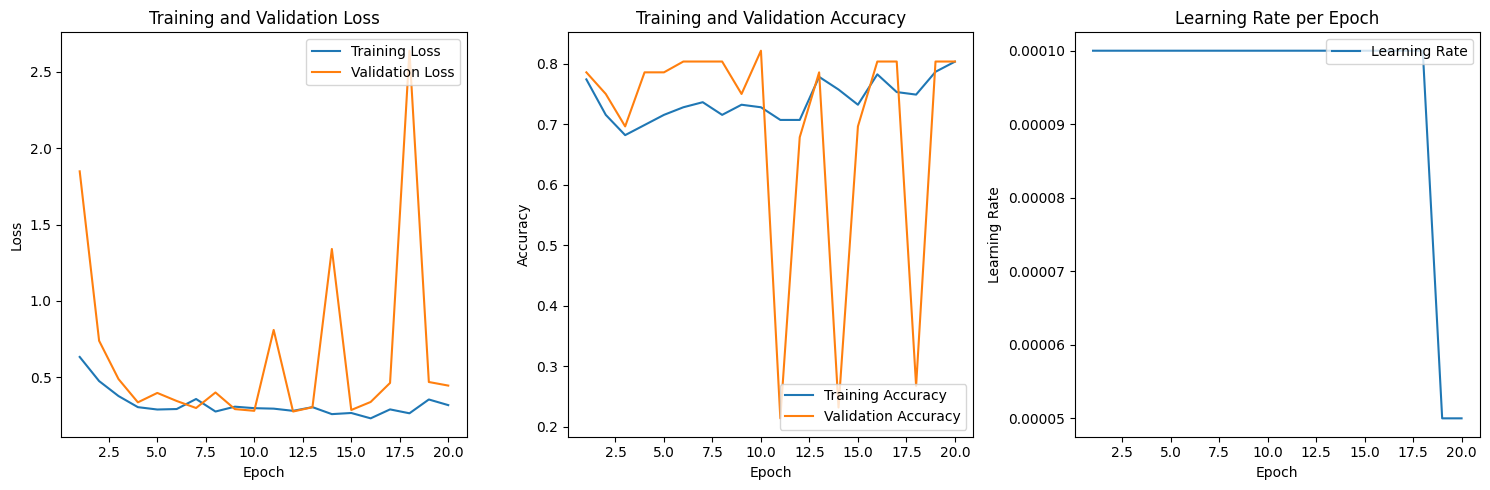

<Figure size 640x480 with 0 Axes>

In [17]:
# --- Step 2: Run Training ---
logger.info("Starting Step 2: Training Model...")
do_load_preprocessed_training = True #  <<<<<<<<<<< SET THIS FLAG

trained_model, training_history = run_training_pipeline(do_load_preprocessed=do_load_preprocessed_training)

if training_history:
   plot_training_history(training_history)
logger.info("Finished Step 2: Training Model.")

**Step 3: Run Evaluation**
*   This will use the model trained in Step 2 (`trained_model`).
*   If you want to load a different model, modify the commented-out loading logic.
*   Set `use_preprocessed_evaluation_data` and `evaluate_on_validation_set` as needed.

In [1]:
# --- Step 3: Run Evaluation (Uncomment to execute) ---
logger.info("Starting Step 3: Evaluating Model...")

model_for_evaluation = None
if 'trained_model' in locals() and trained_model is not None:
   model_for_evaluation = trained_model
   logger.info("Using model from the training step for evaluation.")
else:
   # Attempt to load the best model from the default path
   default_best_model_path = os.path.join(MODEL_DIR, "classification", f"{MODEL_NAME}_best.pth")
   if os.path.exists(default_best_model_path):
       logger.info(f"Loading model from checkpoint: {default_best_model_path}")
       model_for_evaluation = get_model_notebook()
       try:
           model_for_evaluation.load_state_dict(torch.load(default_best_model_path, map_location=DEVICE))
           logger.info("Model loaded successfully.")
       except Exception as e:
           logger.error(f"Failed to load model from {default_best_model_path}: {e}")
           model_for_evaluation = None # Ensure it's None if loading failed
   else:
       logger.warning(f"No trained model available from current session, and checkpoint not found at {default_best_model_path}.")

if model_for_evaluation:
   use_preprocessed_evaluation_data = True # <<<<<<<<<<< SET THIS FLAG
   evaluate_on_validation_set = False    # <<<<<<<<<<< SET THIS FLAG (True to use val set, False for test set)
   
   eval_results = run_evaluation_pipeline(
       model_to_evaluate=model_for_evaluation,
       use_preprocessed_test_data=use_preprocessed_evaluation_data,
       use_val_set_instead=evaluate_on_validation_set
   )
   if eval_results:
       logger.info(f"Final Evaluation Accuracy: {eval_results['accuracy']:.4f}")
else:
   logger.error("Cannot run evaluation as no model is available.")

logger.info("Finished Step 3: Evaluating Model.")

NameError: name 'logger' is not defined